In [21]:
from pinntorch import *
from functools import partial
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.ticker import FuncFormatter

In [22]:
K = 5.0

In [23]:
def exact_solution_log(x):
    return 1/(1+torch.exp(-torch.Tensor(K*x)))

# exact solution in NumPy: This one is needed for the loss function becasue somehow the tensor form does not work as of now.
def exact_solution_log_np(x):
    return 1/(1+np.exp(-K*x))

def create_noisy_data(x, std_dev, noise_seed = 42):
    exact = exact_solution_log(x)
    torch.manual_seed(noise_seed)

    return exact + torch.randn(exact.size())*std_dev 

def data_loss(model: PINN, data: torch.Tensor = None, x: torch.Tensor = None) -> torch.float:
    # MSE loss 
    return (f(model, x) - data).pow(2).mean()

def physics_loss(model: PINN, x: torch.Tensor = None) -> torch.float:
    # define PDE loss
    pde_loss_pre = df(model, x) - K*f(model, x)*(1 - f(model, x))
    pde_loss = pde_loss_pre.pow(2).mean()
    
    # define conditional losses (initial + boundary)
    boundary_loss_right_pre = (f(model, at(+1.0)) - exact_solution_log_np(+1)) 
    boundary_loss_right = boundary_loss_right_pre.pow(2).mean()

    # combine all losses
    final_loss = pde_loss + boundary_loss_right
    
    return final_loss


def total_loss(model: PINN, data: torch.Tensor = None, x: torch.Tensor= None, alpha: torch.float= None) -> list:

    """adds the physics and the data loss with coefficients alpha and (1-alpha) respectively"""

    loss_data = data_loss(model,data, x)

    loss_physics = physics_loss(model, x)

    return alpha*loss_data, (1 - alpha)* loss_physics   #TODO: Get rid of the need for element wise operation.

def custom_color_normalize(value):
    return value**80
    

def find_last_threshold_index(physics, validation, threshold = 0.0):
    over = (validation - physics) > threshold
    reversed_arr = np.flipud(over)
    index = len(over) - np.where(reversed_arr == False)[0][0] - 1
    return index

def get_best_indices(physics, validation, threshold = 0.0):
    best_indices = []
    for i in range(len(physics)):
        best_indices.append(find_last_threshold_index(physics[i], validation[i], threshold))
    return best_indices

In [24]:
class ValLRMonitor(EpochCallBack):
    """
    Abstract base class for epoch callback objects.
    """
    def __init__(self, training_points, validation_points, data_values):
        self.data_loss_fn = partial(data_loss, data=data_values, x=training_points)
        self.physics_loss_fn = partial(physics_loss, x=training_points)
        self.val_loss_fn = partial(physics_loss, x=validation_points)

    def prepare(self, max_epochs, model, loss_fn, optimizer):
        self.val_history = []
        self.lr_history = []
        self.data_history = []
        self.physics_history = []

    def process(self, epoch, model, loss_fn, optimizer, current_loss, extra_logs):
        self.lr_history.append(float(optimizer.param_groups[0]["lr"]))
        self.val_history.append(self.val_loss_fn(model).detach().numpy())
        self.data_history.append(self.data_loss_fn(model).detach().numpy())
        self.physics_history.append(self.physics_loss_fn(model).detach().numpy())


In [25]:
def scalar_training(settings, input_data, train_points, val_points):

    L_p = []
    L_d = []
    L_VAL = []
    LR = []
    
    models_trained = []
    for i, alpha in enumerate(settings['alphas']):
        print("i:", i, "alpha:", alpha)
        loss_fn = partial(total_loss,data = input_data, x=train_points, alpha = alpha)  # For each alpha we need a loss function with different alpha. 
             
        torch.manual_seed(settings['model_seed'])
        model = PINN(1, 3, 9, 1)
        #print(list(model.parameters()))
        callbacks = [ValLRMonitor(training_points=train_points, validation_points=val_points, data_values=input_data)]
        trained_model = train_model(
            model = model, 
            loss_fn=loss_fn,
            max_epochs = settings['epochs'],
            lr_decay=2e-2,
            optimizer_fn = partial(torch.optim.Adam, lr=settings['start_learning_rate']),
            epoch_callbacks = callbacks
        )

        L_p.append(np.array(callbacks[0].physics_history))
        L_d.append(np.array(callbacks[0].data_history))
        LR.append(np.array(callbacks[0].lr_history))
        L_VAL.append(np.array(callbacks[0].val_history))
        models_trained.append(trained_model)

    return L_p, L_d, LR, L_VAL, models_trained

In [26]:
settings = {}

# create alpha list
alphas = 1-torch.logspace(start=-2, end=0.0, steps=20, base=80)


settings['n_train_points'] = 20
settings['n_val_points'] = 39
settings['noise_level'] = 0.1
settings['epochs'] = 20_000
settings['alphas'] = alphas.cpu()
settings['noise_seed'] = 123
settings['model_seed'] = 42
settings['start_learning_rate'] = 0.003

training_points = generate_grid((settings['n_train_points']), (-1.0,1.0))
validation_points = generate_grid((settings['n_val_points']), (-1.0,1.0))

data_noise = create_noisy_data(training_points, settings['noise_level'], noise_seed=settings['noise_seed'])

In [27]:
Loss_physics, Loss_data, LR_evolution, Loss_val, models_trained = scalar_training(settings, data_noise, training_points, validation_points)

i: 0 alpha: tensor(0.9998)
[Parameter containing:
tensor([[-0.2525],
        [ 0.2616],
        [ 0.4939],
        [ 0.3576],
        [-0.6847],
        [-0.4658],
        [-0.1222],
        [ 0.7493],
        [ 0.1121]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.2006,  0.3205, -0.2950, -0.5014,  0.5654, -0.3522, -0.1553, -0.7706,
          0.5184]], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([[ 0.4374,  0.2104, -0.4026, -0.5698, -0.4689,  0.4305,  0.2772,  0.4858,
          0.3025],
        [ 0.1461, -0.0057, -0.4391, -0.4947, -0.5400,  0.2363, -0.2835, -0.1162,
         -0.3323],
        [-0.1052, -0.4064, -0.3772,  0.1915, -0.1716,  0.3564, -0.1852, -0.4235,
         -0.1019],
        [-0.2799, -0.1766, -0.5496,  0.3230, -0.4020,  0.2902,  0.2620,  0.4125,
         -0.4429],
        [ 0.4152, -0.2729,  0.2142,  0.5422, -0

In [11]:
def tick_formatter(val, pos):
    skip_indices = [1,2,3,5,15,16,17,18,19,20]  # alpha indices to skip showing
    if pos in skip_indices:
        return ''
    elif pos == 1:
        return '('+str(1.0)+')'
    return alphas[pos]

def plot_pareto_front(L_D, L_P, data_color, xtick_rotation=0, file_name='heat_pareto_noname', bbox_bounds = (0.1, -0.1, 5.2, 3.8)):
    cmap = matplotlib.colormaps['jet']
    plt.figure(figsize=(5,4))
    low_noise_points = plt.scatter(L_D, L_P, c=custom_color_normalize(data_color), cmap=cmap)  # Use 'viridis' colormap, but you can choose any other
    # Add colorbar for the z values
    cbar_lown = plt.colorbar(low_noise_points, ticks=custom_color_normalize(np.concatenate(([1.0], data_color))), format=FuncFormatter(tick_formatter))

    cbar_lown.set_label(r' $α$ (log scaled)', fontsize=13)
    
    plt.ylabel(r"$\mathcal{L}_\mathrm{PHYSICS}$", loc='center', fontsize=13)
    plt.xlabel(r"$\mathcal{L}_\mathrm{DATA}$", loc='center', fontsize=13)

    plt.grid()

    bbox_instance = Bbox.from_bounds(*bbox_bounds)
    plt.xticks(rotation=xtick_rotation)

    plt.savefig(file_name+'.png', dpi=600, bbox_inches=bbox_instance)
    plt.show()

In [13]:
Loss_data[0]

array([0.24744368, 0.2029926 , 0.16489509, ..., 0.00181893, 0.0018189 ,
       0.00181884], dtype=float32)

In [63]:
alphas = np.array(alphas)

log_data = np.array(Loss_data) 
log_physics = np.array(Loss_physics) 
log_val = np.array(Loss_val)

In [65]:
log_data.shape

(20, 20000)

In [61]:
# calculate the non-overfitted indices for all 20 runs
best_indices = get_best_indices(log_physics, log_val, 0.0)

# extract data loss and physics loss according to the indices
log_best_data = [log_data[i][best_indices[i]] for i in range(len(log_data))]
log_best_physics = [log_physics[i][best_indices[i]] for i in range(len(log_physics))]

IndexError: index 0 is out of bounds for axis 0 with size 0

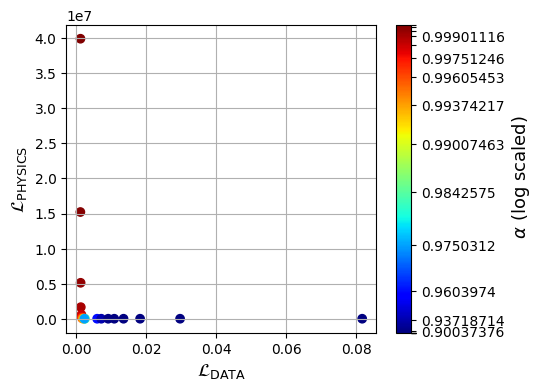

In [62]:
plot_pareto_front(log_best_data, log_best_physics, alphas, 0, 'log_best', (0.1, -0.1, 5.2, 3.8))